In [55]:
# Cell 1｜Imports + Paths + DuckDB connect

import duckdb
import numpy as np
import pandas as pd
from pathlib import Path

from scipy.stats import norm, chisquare
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt

DATA_DIR = Path("../data")
SALT = "pdp_ui_v1"
ASSIGN_PATH = DATA_DIR / f"assignment_{SALT}.parquet"

assert ASSIGN_PATH.exists(), f"Missing: {ASSIGN_PATH}"

con = duckdb.connect(database=":memory:")

con.execute(f"""
CREATE OR REPLACE VIEW assignment AS
SELECT *
FROM read_parquet('{ASSIGN_PATH.as_posix()}')
""")

# Quick sanity
con.execute("SELECT COUNT(*) AS n FROM assignment").df()


,n
0,5316128


In [57]:
# Cell 2｜Schema check + load REAL segments (Phase 3) + create base view

cols = con.execute("DESCRIBE assignment").df()
display(cols)

colset = set(cols["column_name"].tolist())

def col_exists(name): 
    return name in colset

# ---- Exposure / outcome (prefer boolean) ----
# PDP experiment requires VIEW exposure
if col_exists("view"):
    exposure_expr = "CAST(view AS INTEGER) = 1"
elif col_exists("view_time"):
    exposure_expr = "view_time IS NOT NULL"
else:
    raise ValueError("No exposure column found. Need 'view' or 'view_time' for PDP exposure.")

# Primary outcome = CART (Add-to-Cart)
if col_exists("cart"):
    outcome_expr = "CAST(cart AS INTEGER) = 1"
elif col_exists("cart_time"):
    outcome_expr = "cart_time IS NOT NULL"
else:
    raise ValueError("No outcome column found. Need 'cart' or 'cart_time' for Add-to-Cart outcome.")

print("Using exposure expr:", exposure_expr)
print("Using outcome expr:", outcome_expr)

# ---- Load real segment table (Phase 3 output) ----
SEG_PATH = DATA_DIR / "user_segment.csv"

if SEG_PATH.exists():
    con.execute(f"""
    CREATE OR REPLACE VIEW user_segment AS
    SELECT
      CAST("user_id" AS BIGINT) AS user_id,
      CAST("user_type" AS VARCHAR) AS user_segment,
      "first_seen_time" AS first_seen_time
    FROM read_csv_auto('{SEG_PATH.as_posix()}', HEADER=TRUE)
    """)
    print("✅ Real segments loaded from:", SEG_PATH)

    seg_counts = con.execute("""
    SELECT user_segment, COUNT(*) AS n
    FROM user_segment
    GROUP BY user_segment
    ORDER BY n DESC
    """).df()
    display(seg_counts)
else:
    con.execute("""
    CREATE OR REPLACE VIEW user_segment AS
    SELECT CAST(NULL AS BIGINT) AS user_id,
           CAST(NULL AS VARCHAR) AS user_segment,
           CAST(NULL AS VARCHAR) AS first_seen_time
    WHERE FALSE
    """)
    print("⚠️ Missing user_segment.csv. Will default to 'Unknown'.")

# ---- Create base view with REAL segment attached ----
con.execute(f"""
CREATE OR REPLACE VIEW base AS
SELECT
  a.user_id,
  CAST(a.variant AS INTEGER) AS variant,
  ({exposure_expr}) AS exposed,
  ({outcome_expr}) AS cart,
  COALESCE(s.user_segment, 'Unknown') AS segment_raw
FROM assignment a
LEFT JOIN user_segment s
ON a.user_id = s.user_id
""")

# ---- Sanity check: overall rates + segment coverage ----
overall = con.execute("""
SELECT 
  COUNT(*) AS n,
  AVG(CASE WHEN exposed THEN 1 ELSE 0 END) AS exposed_rate,
  AVG(CASE WHEN cart THEN 1 ELSE 0 END) AS cart_rate,
  AVG(CASE WHEN segment_raw <> 'Unknown' THEN 1 ELSE 0 END) AS segment_coverage
FROM base
""").df()

display(overall)

segment_check = con.execute("""
SELECT segment_raw, COUNT(*) AS n
FROM base
GROUP BY segment_raw
ORDER BY n DESC
LIMIT 20
""").df()

display(segment_check)


,column_name,column_type,null,key,default,extra
0,user_id,BIGINT,YES,None,None,None
1,variant,INTEGER,YES,None,None,None
2,view,BOOLEAN,YES,None,None,None
3,cart,BOOLEAN,YES,None,None,None
4,purchase,BOOLEAN,YES,None,None,None


Using exposure expr: CAST(view AS INTEGER) = 1
Using outcome expr: CAST(cart AS INTEGER) = 1
✅ Real segments loaded from: ..\data\user_segment.csv


,user_segment,n
0,returning,4877171
1,new,439478


,n,exposed_rate,cart_rate,segment_coverage
0,5316128,1.0,0.198001,1.0


,segment_raw,n
0,returning,4876696
1,new,439432


In [58]:
# Cell 3｜Define treatment eligibility + parameters (Exposure-aware uplift on cart)

con.execute("""
CREATE OR REPLACE VIEW base_flags AS
SELECT
  *,
  (variant = 1) AS in_treatment_group,
  (variant = 1 AND exposed) AS treated_exposed
FROM base
""")

# Uplift parameters (relative lift on cart probability within exposed viewers)
UPLIFT_REL = 0.05  # 5% relative lift within exposed (adjust: 0.02 ~ 0.07)
SEED = 42

UPLIFT_REL, SEED


(0.05, 42)

In [59]:
# Cell 4｜Compute baseline cart rate among exposed control + delta

np.random.seed(SEED)

baseline = con.execute("""
SELECT
  AVG(CASE WHEN cart THEN 1 ELSE 0 END) AS p0_cart_exposed_control
FROM base_flags
WHERE variant = 0 AND exposed
""").df()

p0 = float(baseline.loc[0, "p0_cart_exposed_control"])
p1 = min(1.0, p0 * (1.0 + UPLIFT_REL))
delta = max(0.0, p1 - p0)

p0, p1, delta


(0.19822363487716696, 0.20813481662102531, 0.009911181743858355)

In [60]:
# Cell 5｜Materialize simulation results into DuckDB (cart_sim) — one-sided (0->1 only)

df = con.execute("""
SELECT user_id, variant, exposed, cart, treated_exposed, segment_raw
FROM base_flags
""").df()

# Initialize simulated as original
df["cart_sim"] = df["cart"].astype(bool)

# Apply treatment only to exposed users in treatment group, only if not already cart=1
mask = df["treated_exposed"].astype(bool) & (~df["cart"].astype(bool))

# One-sided uplift: create incremental carts with probability = delta
df.loc[mask, "cart_sim"] = (np.random.rand(mask.sum()) < delta) | df.loc[mask, "cart_sim"]

# Push back to DuckDB as a view
con.register("sim_df", df[["user_id", "variant", "exposed", "cart", "cart_sim", "segment_raw"]])

con.execute("""
CREATE OR REPLACE VIEW sim AS
SELECT * FROM sim_df
""")

con.execute("""
SELECT
  COUNT(*) AS n,
  AVG(CASE WHEN cart_sim THEN 1 ELSE 0 END) AS sim_cart_rate
FROM sim
""").df()


,n,sim_cart_rate
0,5316128,0.201993


In [61]:
# Cell 6｜Estimate ITT (Global Impact): all users denominator + CI

itt_tbl = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_users,
  SUM(CASE WHEN cart_sim THEN 1 ELSE 0 END) AS add_to_carts,
  SUM(CASE WHEN exposed THEN 1 ELSE 0 END) AS exposed_users
FROM sim
GROUP BY variant
ORDER BY variant
""").df()

display(itt_tbl)

# Compute ITT + Wald CI
c0_all = itt_tbl.loc[itt_tbl["variant"] == 0, "add_to_carts"].values[0]
c1_all = itt_tbl.loc[itt_tbl["variant"] == 1, "add_to_carts"].values[0]
n0_all = itt_tbl.loc[itt_tbl["variant"] == 0, "n_users"].values[0]
n1_all = itt_tbl.loc[itt_tbl["variant"] == 1, "n_users"].values[0]

p0_all = c0_all / n0_all
p1_all = c1_all / n1_all

itt = p1_all - p0_all
se_itt = np.sqrt(p0_all * (1 - p0_all) / n0_all + p1_all * (1 - p1_all) / n1_all)
ci_itt = (itt - 1.96 * se_itt, itt + 1.96 * se_itt)

z_itt, p_itt = proportions_ztest(
    count=np.array([c1_all, c0_all]),
    nobs=np.array([n1_all, n0_all])
)

summary_itt = pd.DataFrame([{
    "metric": "ITT (Global, Add-to-Cart)",
    "p_treat": p1_all,
    "p_control": p0_all,
    "diff": itt,
    "ci_low": ci_itt[0],
    "ci_high": ci_itt[1],
    "z": z_itt,
    "p_value": p_itt,
    "note": ""
}])

summary_itt


,variant,n_users,add_to_carts,exposed_users
0,0,2659138,527104.0,2659138.0
1,1,2656990,546715.0,2656990.0


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value,note
0,"ITT (Global, Add-to-Cart)",0.205765,0.198224,0.007541,0.006859,0.008224,21.65382,5.594538e-104,


In [63]:
# Cell 7｜Estimate CATE on Exposed (Local Impact): exposed users only + CI

cate_tbl = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_exposed,
  SUM(CASE WHEN cart_sim THEN 1 ELSE 0 END) AS add_to_carts_exposed
FROM sim
WHERE exposed
GROUP BY variant
ORDER BY variant
""").df()

display(cate_tbl)

c0_exp = cate_tbl.loc[cate_tbl["variant"] == 0, "add_to_carts_exposed"].values[0]
c1_exp = cate_tbl.loc[cate_tbl["variant"] == 1, "add_to_carts_exposed"].values[0]
n0_exp = cate_tbl.loc[cate_tbl["variant"] == 0, "n_exposed"].values[0]
n1_exp = cate_tbl.loc[cate_tbl["variant"] == 1, "n_exposed"].values[0]

p0_exp = c0_exp / n0_exp
p1_exp = c1_exp / n1_exp

cate = p1_exp - p0_exp
se_cate = np.sqrt(p0_exp * (1 - p0_exp) / n0_exp + p1_exp * (1 - p1_exp) / n1_exp)
ci_cate = (cate - 1.96 * se_cate, cate + 1.96 * se_cate)

z_cate, p_cate = proportions_ztest(
    count=np.array([c1_exp, c0_exp]),
    nobs=np.array([n1_exp, n0_exp])
)

summary_cate = pd.DataFrame([{
    "metric": "CATE (Local, Exposed Only, Add-to-Cart)",
    "p_treat": p1_exp,
    "p_control": p0_exp,
    "diff": cate,
    "ci_low": ci_cate[0],
    "ci_high": ci_cate[1],
    "z": z_cate,
    "p_value": p_cate,
    "note": ""
}])

summary_cate


,variant,n_exposed,add_to_carts_exposed
0,0,2659138,527104.0
1,1,2656990,546715.0


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value,note
0,"CATE (Local, Exposed Only, Add-to-Cart)",0.205765,0.198224,0.007541,0.006859,0.008224,21.65382,5.594538e-104,


In [64]:
# Cell 8｜Placebo / Sanity Check: non-exposed should show ~0 effect (robust to empty support)

placebo_tbl = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_non_exposed,
  SUM(CASE WHEN cart_sim THEN 1 ELSE 0 END) AS add_to_carts_non_exposed
FROM sim
WHERE NOT exposed
GROUP BY variant
ORDER BY variant
""").df()

display(placebo_tbl)

need_variants = {0, 1}
have_variants = set(placebo_tbl["variant"].tolist()) if len(placebo_tbl) > 0 else set()

def safe_summary_placebo(reason: str):
    return pd.DataFrame([{
        "metric": "Placebo (Non-exposed, Add-to-Cart)",
        "p_treat": np.nan,
        "p_control": np.nan,
        "diff": 0.0,
        "ci_low": np.nan,
        "ci_high": np.nan,
        "z": np.nan,
        "p_value": 1.0,
        "note": reason
    }])

if have_variants != need_variants:
    missing = need_variants - have_variants
    summary_placebo = safe_summary_placebo(
        f"Placebo not computable: missing variant(s) in non-exposed sample: {sorted(list(missing))}. "
        f"Likely because NOT exposed has zero rows for that arm (exposed_rate may be ~1.0 under this exposure definition)."
    )
else:
    n0_ne = int(placebo_tbl.loc[placebo_tbl["variant"] == 0, "n_non_exposed"].values[0])
    n1_ne = int(placebo_tbl.loc[placebo_tbl["variant"] == 1, "n_non_exposed"].values[0])

    if n0_ne == 0 or n1_ne == 0:
        summary_placebo = safe_summary_placebo(
            f"Placebo not computable: non-exposed sample size is zero in one arm (n0={n0_ne}, n1={n1_ne})."
        )
    else:
        c0_ne = int(placebo_tbl.loc[placebo_tbl["variant"] == 0, "add_to_carts_non_exposed"].values[0])
        c1_ne = int(placebo_tbl.loc[placebo_tbl["variant"] == 1, "add_to_carts_non_exposed"].values[0])

        p0_ne = c0_ne / n0_ne
        p1_ne = c1_ne / n1_ne

        diff_ne = p1_ne - p0_ne
        se_ne = np.sqrt(p0_ne * (1 - p0_ne) / n0_ne + p1_ne * (1 - p1_ne) / n1_ne)
        ci_ne = (diff_ne - 1.96 * se_ne, diff_ne + 1.96 * se_ne)

        z_ne, p_ne = proportions_ztest(
            count=np.array([c1_ne, c0_ne]),
            nobs=np.array([n1_ne, n0_ne])
        )

        summary_placebo = pd.DataFrame([{
            "metric": "Placebo (Non-exposed, Add-to-Cart)",
            "p_treat": p1_ne,
            "p_control": p0_ne,
            "diff": diff_ne,
            "ci_low": ci_ne[0],
            "ci_high": ci_ne[1],
            "z": z_ne,
            "p_value": p_ne,
            "note": ""
        }])

summary_placebo


,variant,n_non_exposed,add_to_carts_non_exposed


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value,note
0,"Placebo (Non-exposed, Add-to-Cart)",NaN,NaN,0.0,NaN,NaN,NaN,1.0,Placebo not computable: missing variant(s) in ...


In [65]:
# Cell 9｜Heterogeneity within exposed: New vs Returning (production-grade)

df2 = df.copy()

if "segment_raw" not in df2.columns:
    raise ValueError("segment_raw missing — ensure Cell 5 SELECT includes segment_raw and it is registered back to DuckDB.")

raw = df2["segment_raw"].astype("string").str.strip()
raw = raw.replace({"": pd.NA})
raw_lc = raw.str.lower()

UNKNOWN_TOKENS = {"unknown", "na", "n/a", "nan", "none", "null", "<na>", "missing", "undefined"}
is_missing = raw.isna()
is_unknown = raw_lc.isin(list(UNKNOWN_TOKENS))

total_n = len(df2)
known_n = int((~is_missing & ~is_unknown).sum())
print(f"[Segment Audit] total={total_n:,} | real_segment_rows={known_n:,} | coverage={known_n/total_n:.2%}")

# Map segment labels to {New, Returning, Unknown, Other}
s = raw.fillna("Unknown").astype("string").str.strip()
ss = s.str.lower()

c_unknown = (ss.isin(list(UNKNOWN_TOKENS)) | ss.eq("unknown")).fillna(False).to_numpy(dtype=bool)
c_new = (ss.str.contains("new", na=False) | ss.str.contains("first", na=False)).to_numpy(dtype=bool)
c_ret = (
    ss.str.contains("return", na=False)
    | ss.str.contains("exist", na=False)
    | ss.str.contains("old", na=False)
    | ss.str.contains("repeat", na=False)
).to_numpy(dtype=bool)

df2["segment"] = np.select(
    [c_unknown, c_new, c_ret],
    ["Unknown", "New", "Returning"],
    default="Other"
)

# Keep only exposed users for heterogeneity
hexp = df2[df2["exposed"]].copy()

het = (hexp
       .groupby(["segment", "variant"], dropna=False)
       .agg(
           n_users=("user_id", "size"),
           add_to_carts=("cart_sim", "sum")
       )
       .reset_index())

het["add_to_cart_rate"] = het["add_to_carts"] / het["n_users"]

print("[Segment Distribution in Exposed]")
display(het.groupby("segment")["n_users"].sum().sort_values(ascending=False).to_frame("n_exposed_users"))

het


[Segment Audit] total=5,316,128 | real_segment_rows=5,316,128 | coverage=100.00%
[Segment Distribution in Exposed]


,n_exposed_users
segment,
Returning,4876696
New,439432


,segment,variant,n_users,add_to_carts,add_to_cart_rate
0,New,0,220146,26012,0.118158
1,New,1,219286,27432,0.125097
2,Returning,0,2438992,501092,0.205450
3,Returning,1,2437704,519283,0.213021


,segment,diff,ci_low,ci_high,p0,p1,n0,n1
0,New,0.006939,0.005006,0.008872,0.118158,0.125097,220146.0,219286.0
1,Returning,0.007571,0.006849,0.008293,0.205450,0.213021,2438992.0,2437704.0


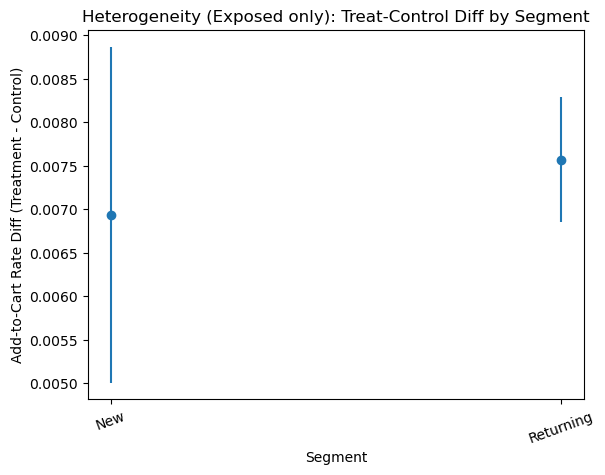

In [67]:
# Cell 10｜Heterogeneity: effect (treat-control) within each segment + CI + plot

def diff_ci_for_segment(seg_df):
    # Require both variants present
    if seg_df["variant"].nunique() < 2:
        return pd.Series({
            "diff": np.nan, "ci_low": np.nan, "ci_high": np.nan,
            "p0": np.nan, "p1": np.nan, "n0": np.nan, "n1": np.nan
        })

    d0 = seg_df[seg_df["variant"] == 0]
    d1 = seg_df[seg_df["variant"] == 1]
    if len(d0) == 0 or len(d1) == 0:
        return pd.Series({
            "diff": np.nan, "ci_low": np.nan, "ci_high": np.nan,
            "p0": np.nan, "p1": np.nan, "n0": np.nan, "n1": np.nan
        })

    d0 = d0.iloc[0]
    d1 = d1.iloc[0]

    p0 = float(d0["add_to_cart_rate"]); p1 = float(d1["add_to_cart_rate"])
    n0 = float(d0["n_users"]); n1 = float(d1["n_users"])

    diff = p1 - p0
    se = np.sqrt(p0*(1-p0)/n0 + p1*(1-p1)/n1) if (n0 > 0 and n1 > 0) else np.nan
    ci = (diff - 1.96*se, diff + 1.96*se) if pd.notna(se) else (np.nan, np.nan)

    return pd.Series({"diff": diff, "ci_low": ci[0], "ci_high": ci[1], "p0": p0, "p1": p1, "n0": n0, "n1": n1})

het_effect = (het.groupby("segment")
              .apply(diff_ci_for_segment)
              .reset_index())

display(het_effect)

plt.figure()
ok = het_effect["diff"].notna()
plt.errorbar(
    x=het_effect.loc[ok, "segment"].astype(str),
    y=het_effect.loc[ok, "diff"],
    yerr=[
        het_effect.loc[ok, "diff"] - het_effect.loc[ok, "ci_low"],
        het_effect.loc[ok, "ci_high"] - het_effect.loc[ok, "diff"]
    ],
    fmt="o"
)
plt.title("Heterogeneity (Exposed only): Treat-Control Diff by Segment")
plt.xlabel("Segment")
plt.ylabel("Add-to-Cart Rate Diff (Treatment - Control)")
plt.xticks(rotation=20)
plt.show()


In [68]:
# Cell 11｜One-page summary table (ITT + CATE + Placebo) for README screenshot

summary = pd.concat([summary_itt, summary_cate, summary_placebo], ignore_index=True)

summary_fmt = summary.copy()
for c in ["p_treat","p_control","diff","ci_low","ci_high"]:
    summary_fmt[c] = pd.to_numeric(summary_fmt[c], errors="coerce")

summary_fmt


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value,note
0,"ITT (Global, Add-to-Cart)",0.205765,0.198224,0.007541,0.006859,0.008224,21.65382,5.594538e-104,
1,"CATE (Local, Exposed Only, Add-to-Cart)",0.205765,0.198224,0.007541,0.006859,0.008224,21.65382,5.594538e-104,
2,"Placebo (Non-exposed, Add-to-Cart)",NaN,NaN,0.000000,NaN,NaN,NaN,1.000000e+00,Placebo not computable: missing variant(s) in ...
